### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":False,
    "type": None,
    "B": 10.5,
    "L": 155.75,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 7, 801)          # ship sailing speeds to water, (m/s)
h_0 = [3,3.5,4,5,6,7,8,9,10,20]                 # water depths,(m)
T = [2]   # draught


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
8005,2,20.0,6.965500
8006,2,20.0,6.974125
8007,2,20.0,6.982750
8008,2,20.0,6.991375
8009,2,20.0,7.000000


### Run OpenTNSim to Calculate resistance, required power

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s, h_0)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_d'] = P_tot

    results.append(result)

8010it [00:02, 2806.01it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,P_d,V_s_km
0,2.0,3.0,0.100000,780.0,0.039654,0.044688,0.004957,7.800271e-60,0.005710,0.055354,49.935815,0.36000
1,2.0,3.0,0.108625,780.0,0.045986,0.051823,0.005748,2.322563e-55,0.006737,0.064308,49.939959,0.39105
2,2.0,3.0,0.117250,780.0,0.052734,0.059428,0.006592,1.630175e-51,0.007849,0.073869,49.944746,0.42210
3,2.0,3.0,0.125875,780.0,0.059893,0.067496,0.007487,3.598039e-48,0.009046,0.084028,49.950220,0.45315
4,2.0,3.0,0.134500,780.0,0.067458,0.076021,0.008432,3.098930e-45,0.010327,0.094781,49.956423,0.48420
5,2.0,3.0,0.143125,780.0,0.075424,0.084998,0.009428,1.228337e-42,0.011694,0.106120,49.963396,0.51525
6,2.0,3.0,0.151750,780.0,0.083786,0.094422,0.010473,2.547417e-40,0.013146,0.118041,49.971179,0.54630
7,2.0,3.0,0.160375,780.0,0.092541,0.104288,0.011568,3.058843e-38,0.014682,0.130538,49.979814,0.57735
8,2.0,3.0,0.169000,780.0,0.101685,0.114592,0.012711,2.306250e-36,0.016304,0.143606,49.989341,0.60840
9,2.0,3.0,0.177625,780.0,0.111213,0.125330,0.013902,1.165946e-34,0.018010,0.157241,49.999800,0.63945


In [9]:
plot_df.tail(25)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,P_d,V_s_km
7985,2.0,20.0,6.793000,780.0,67.897665,76.516353,8.487208,102.744074,30.392964,218.140599,2899.591320,24.45480
7986,2.0,20.0,6.801625,780.0,68.059341,76.698552,8.507418,102.998951,30.456852,218.661772,2910.026489,24.48585
7987,2.0,20.0,6.810250,780.0,68.221198,76.880954,8.527650,103.253269,30.520857,219.182729,2920.476120,24.51690
7988,2.0,20.0,6.818875,780.0,68.383235,77.063559,8.547904,103.507416,30.584980,219.703860,2930.945306,24.54795
7989,2.0,20.0,6.827500,780.0,68.545452,77.246368,8.568182,103.761793,30.649221,220.225563,2941.439296,24.57900
7990,2.0,20.0,6.836125,780.0,68.707850,77.429380,8.588481,104.016806,30.713579,220.748246,2951.963462,24.61005
7991,2.0,20.0,6.844750,780.0,68.870428,77.612595,8.608804,104.272865,30.778054,221.272317,2962.523259,24.64110
7992,2.0,20.0,6.853375,780.0,69.033186,77.796013,8.629148,104.530383,30.842646,221.798191,2973.124191,24.67215
7993,2.0,20.0,6.862000,780.0,69.196125,77.979635,8.649516,104.789772,30.907356,222.326278,2983.771773,24.70320
7994,2.0,20.0,6.870625,780.0,69.359244,78.163460,8.669905,105.051438,30.972183,222.856986,2994.471492,24.73425


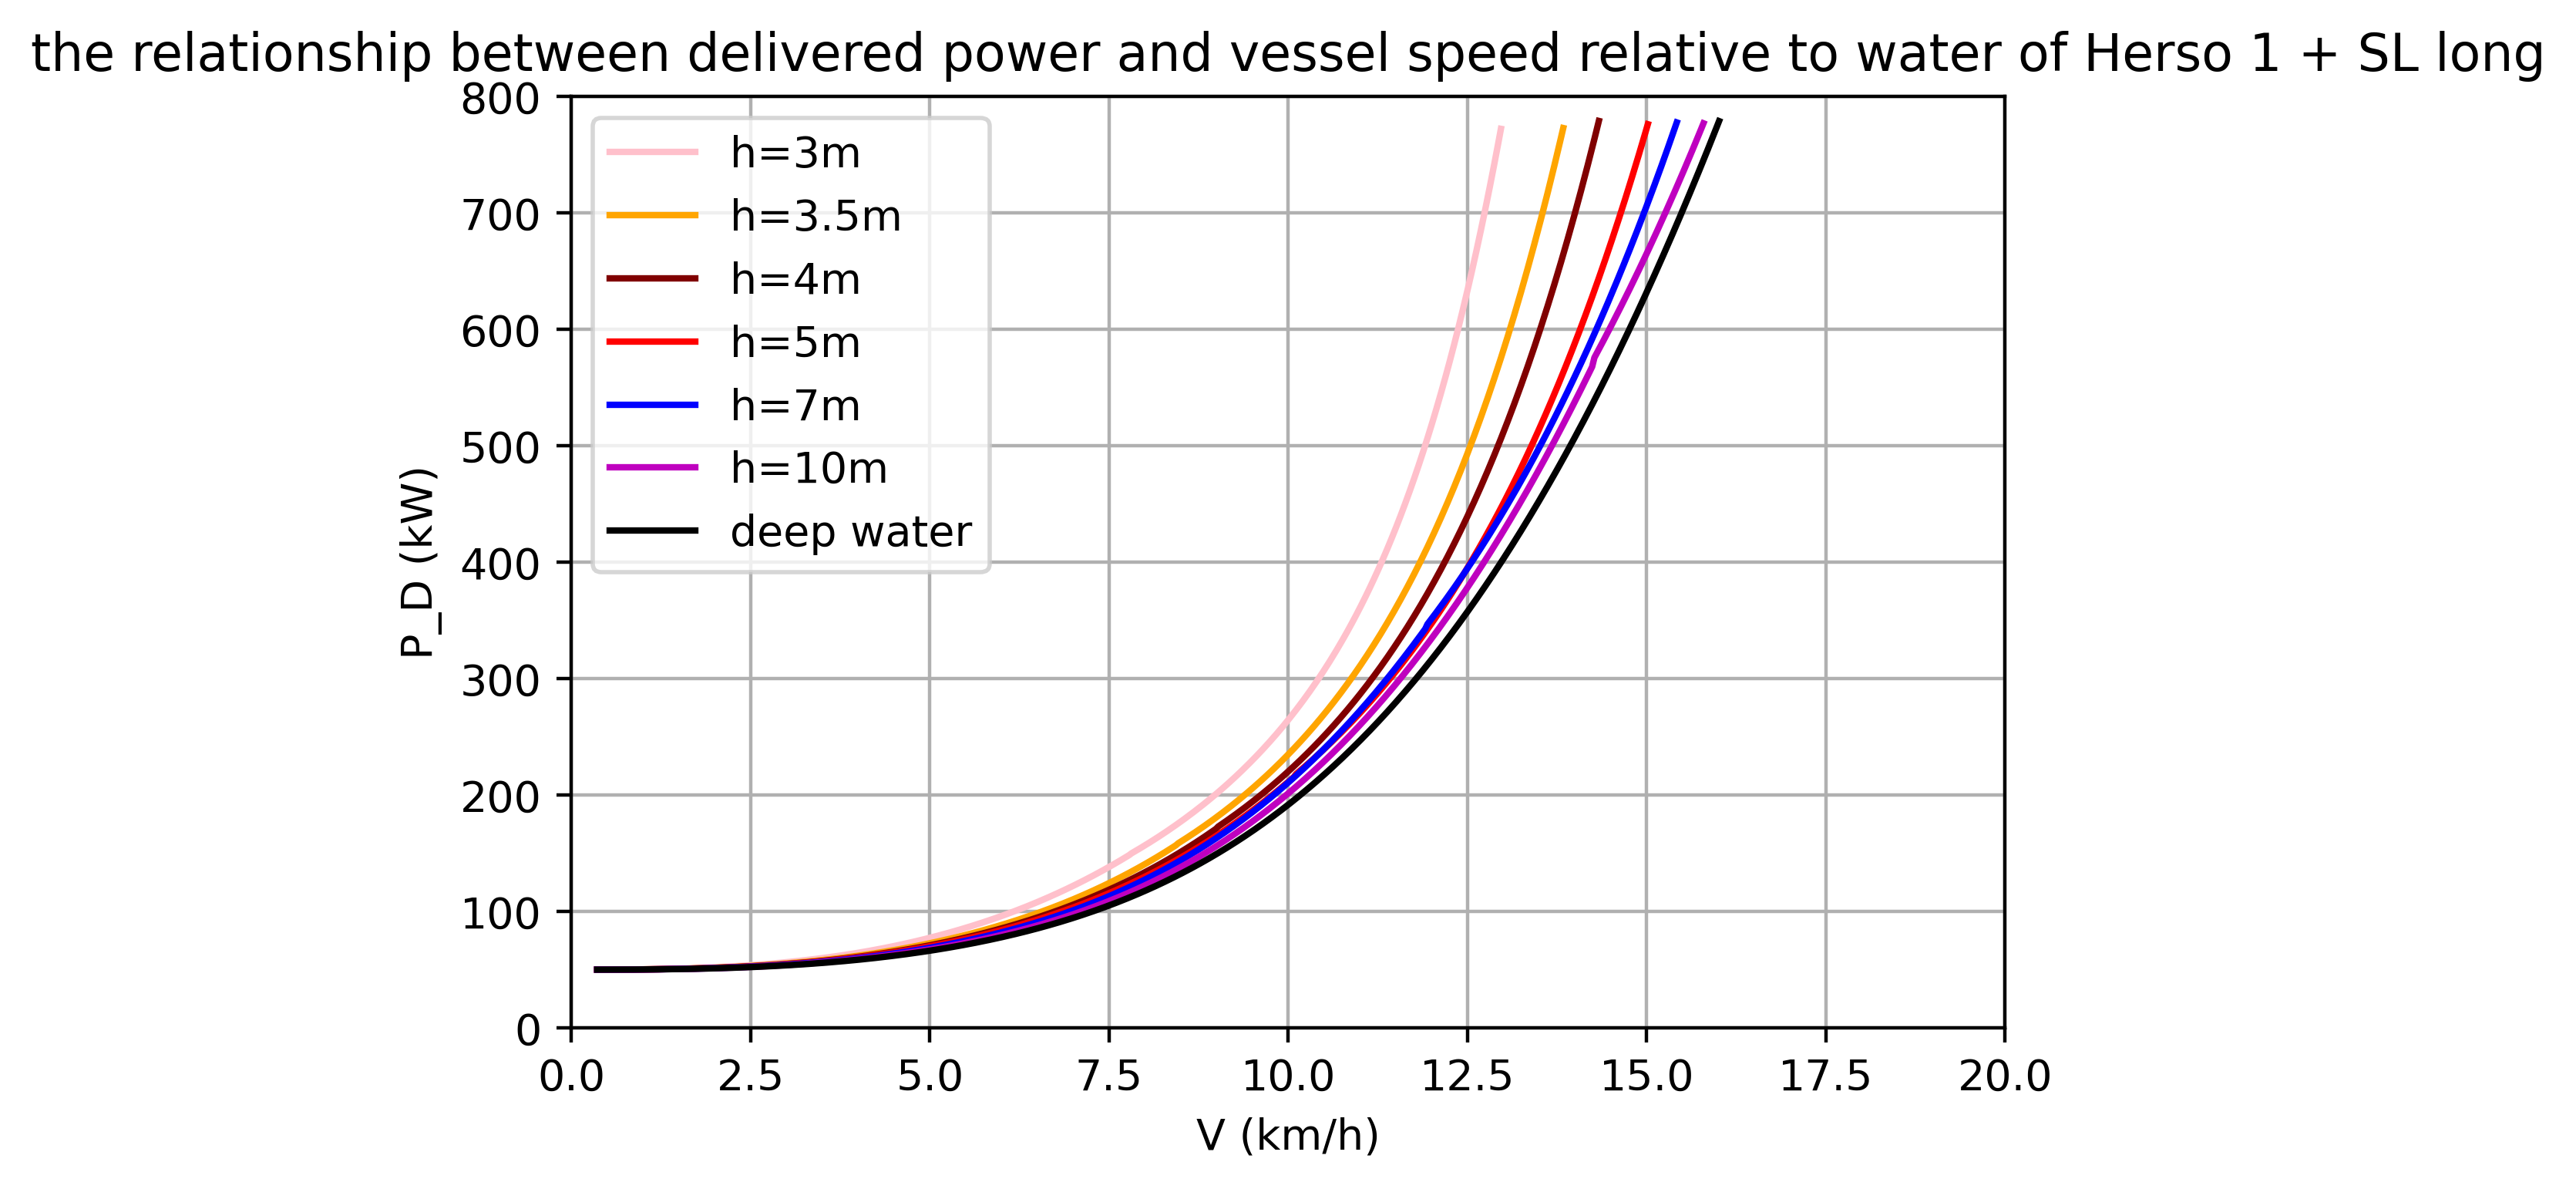

In [10]:
selected_h_3 = plot_df.query('h_0 == 3 & P_d < P_installed')
selected_h_3_5 = plot_df.query('h_0 == 3.5 & P_d < P_installed')
selected_h_4 = plot_df.query('h_0 == 4 & P_d < P_installed')
selected_h_5 = plot_df.query('h_0 == 5 & P_d < P_installed')
selected_h_6 = plot_df.query('h_0 == 6 & P_d < P_installed')
selected_h_7 = plot_df.query('h_0 == 7 & P_d < P_installed')
selected_h_8 = plot_df.query('h_0 == 8 & P_d < P_installed')
selected_h_9 = plot_df.query('h_0 == 9 & P_d < P_installed')
selected_h_10 = plot_df.query('h_0 == 10 & P_d < P_installed')
selected_h_deep = plot_df.query('h_0 == 20 & P_d < P_installed')
plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_d'], 'pink', linewidth = 1.5)
plt.plot(selected_h_3_5['V_s_km'],selected_h_3_5['P_d'], 'orange', linewidth = 1.5)
plt.plot(selected_h_4['V_s_km'],selected_h_4['P_d'], 'maroon', linewidth = 1.5)
plt.plot(selected_h_5['V_s_km'],selected_h_5['P_d'], 'r', linewidth = 1.5)
# plt.plot(selected_h_6['V_s_km'],selected_h_6['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_7['V_s_km'],selected_h_7['P_d'], 'b', linewidth = 1.5)
# plt.plot(selected_h_8['V_s_km'],selected_h_8['P_d'], 'r', linewidth = 1.0)
# plt.plot(selected_h_9['V_s_km'],selected_h_9['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_10['V_s_km'],selected_h_10['P_d'], 'm', linewidth = 1.5)
plt.plot(selected_h_deep['V_s_km'],selected_h_deep['P_d'], 'k', linewidth = 1.5)

plt.xlabel('V (km/h)')
plt.ylabel('P_D (kW)')
plt.legend(['h=3m','h=3.5m','h=4m','h=5m','h=7m','h=10m','deep water'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0,800)
plt.title('the relationship between delivered power and vessel speed relative to water of Herso 1 + SL long');